In [9]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [2]:
with open("../game_state_dqn.txt", "r") as f:
    lines = f.readlines()
states = [list(map(float, line.strip().split())) for line in lines[::2]]
actions = [float(line.strip()) for line in lines[1::2]]

In [3]:
def state_to_struct(state: list) -> dict:
    walls = np.array(state[:12]).reshape(6, 2)
    n_slots = state[13:16].index(1) + 4
    cur_slot = next(i for i, x in enumerate(state[16:16+6]) if x > 0)
    return {
        "walls": walls,
        "n_slots": n_slots,
        "cur_slot": cur_slot,
        "player_pos": state[22] * n_slots,
        "world_rotation": state[23],
    }

def get_cur_wall_dist(state_struct: dict) -> tuple:
    dist, width = state_struct["walls"][state_struct["cur_slot"]]
    return dist, width

def get_cur_center_offset(state_struct: dict) -> float:
    # -1: left edge, 0: center, 1: right edge
    pos = state_struct["player_pos"] * state_struct["n_slots"] 
    return (pos % 1.0) * 2.0 - 1.0

state_struct = state_to_struct(list(states[1000]))
print(get_cur_wall_dist(state_struct))
print(get_cur_center_offset(state_struct))
state_struct

(0.584683, 0.036819)
0.5999920000000003


{'walls': array([[0.36377 , 0.036819],
        [0.145066, 0.036819],
        [0.584683, 0.036819],
        [0.145066, 0.036819],
        [0.36377 , 0.036819],
        [0.145066, 0.036819]]),
 'n_slots': 6,
 'cur_slot': 2,
 'player_pos': 2.466666,
 'world_rotation': -1.0}

In [67]:
import torch
p = torch.tensor([[1,2,3], [-1,-2,0]], dtype=torch.float32)
c = torch.distributions.Categorical(logits=p)
c.sample()

tensor([2, 2])

1000it [01:53,  8.83it/s]


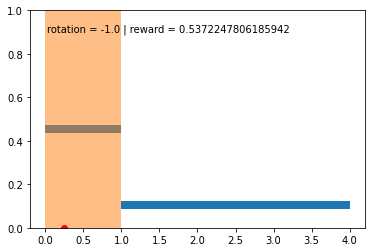

In [6]:
default_reward = 0.1
reward_slot_center_amount = 0.2

def reward(state_struct):
    r = default_reward
    center_offset = get_cur_center_offset(state_struct)
    r += reward_slot_center_amount * pow(1 - abs(center_offset), 4)
    wall_dist, wall_width = get_cur_wall_dist(state_struct)
    r += wall_dist
    return r

def plot_state(ax, state):
    state_struct = state_to_struct(state)
    ax.set_ylim(0, 1.0)
    ax.bar(list(range(state_struct["n_slots"])), height=state_struct["walls"][:state_struct["n_slots"],1], bottom=state_struct["walls"][:state_struct["n_slots"],0], width=1.0, align='edge')
    cur_slot = [0] * state_struct["n_slots"]
    cur_slot[state_struct["cur_slot"]] = 1
    ax.bar(list(range(state_struct["n_slots"])), height=cur_slot, bottom=0, width=1.0, align='edge', alpha=0.5)  # Current player slot
    ax.plot(state_struct["player_pos"], 0, 'ro')  # Player position
    ax.text(0.02, 0.9, f"rotation = {state_struct['world_rotation']} | reward = {reward(state_struct)}")

fig, ax = plt.subplots()
pathlib.Path("./figs/").mkdir(parents=True, exist_ok=True)
for i, state in tqdm(enumerate(states[1000:2000])):
    ax.cla()
    plot_state(ax, state)
    plt.savefig(f"./figs/{i:05}.png")

In [7]:
import os
os.system("ffmpeg -y -framerate 60 -i ./figs/%05d.png -c:v libx264 dqn_states.mp4")

0

In [39]:
cur_walls = []
for s in states:
    state_struct = state_to_struct(s)
    wall = state_struct["walls"][state_struct["cur_slot"]]
    cur_walls.append(wall)
cur_walls = np.stack(cur_walls)
dists = cur_walls[:, 0] * 5432
widths = cur_walls[:, 1] * 2400

<AxesSubplot:ylabel='Frequency'>

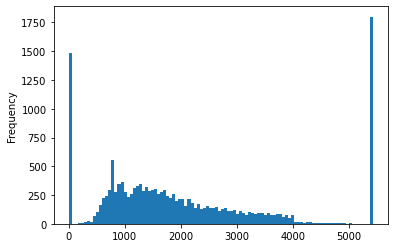

In [40]:
pd.Series(dists).plot.hist(bins=100)

166.9992

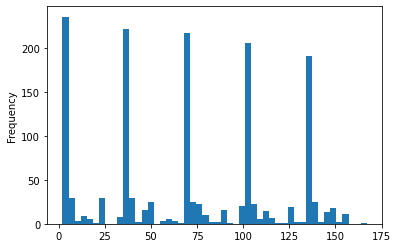

In [41]:
pd.Series(widths[dists < 0.001]).plot.hist(bins=50)
widths[dists < 0.001].max()
# Conclusion: if dist + width < 0.07: false positive wall

<AxesSubplot:ylabel='Frequency'>

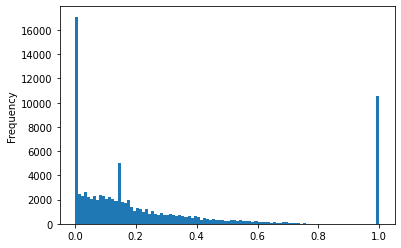

In [6]:
wall_dists = [state_to_struct(s)["walls"][:, 0] for s in states]
pd.Series(np.stack(wall_dists).flatten()).plot.hist(bins=100)

[0.9245396553821594, 0.24907641877394124, -0.5016171990847569]


e:\Mare5\dev\projects\ai-ml\.venv\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in power


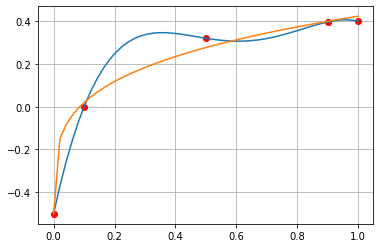

In [50]:
import scipy.optimize
import matplotlib.pyplot as plt

a = -0.5
b = 0.4
thr = 0.07

x = [0, thr, 0.5,  0.9, 1]
y = [a,   0, 0.8*b, 0.99*b, b]
t = np.linspace(0, 1)
plt.plot(x, y, 'ro')

plt.grid()
plt.plot(t, np.polyval(np.polyfit(x, y, 4), t))

def f(x, a, b, c):
    return a*pow(x,b)+c

p = scipy.optimize.curve_fit(f, x, y)[0]
print(p.tolist())
plt.plot(t, [f(x, *p) for x in t])

In [ ]:
for state in states:
    state_struct = state_to_struct(state)
    if state_struct["n_slots"] != 6:
        print(np.where(state_struct["walls"] == [1, 0])[0])

In [4]:
from collections import Counter
Counter(actions)

Counter({1: 9753, 2: 1448, 0: 4409})

In [ ]:
import numpy as np

states = np.array(states, dtype=np.float32)
actions = np.array(actions, dtype=np.int64) + 1  # (-1,0,1) -> (0,1,2)

In [5]:
states.shape, actions.shape

((15610, 23), (15610,))

In [5]:
from qlearning import SupaNet
import torch
import torch.nn as nn

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [13]:
device = torch.device("cuda")

INPUT_SIZE = 6*2 + 1 + 3 + 6 + 1
OUT_SIZE = 3

class SupaNet(nn.Module):
    def __init__(self, sizes=[32, 32]):
        super().__init__()

        sizes = [INPUT_SIZE] + sizes + [OUT_SIZE]
        self.net = nn.Sequential()
        for idx, (in_size, out_size) in enumerate(zip(sizes, sizes[1:])):
            self.net.add_module(str(2*idx), nn.Linear(in_size, out_size))
            if idx < len(sizes) - 2:
                self.net.add_module(str(2*idx + 1), nn.ReLU())

    def forward(self, state):
        return self.net(state)

net = SupaNet()
net.to(device)

SupaNet(
  (net): Sequential(
    (0): Linear(in_features=23, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(states, actions, test_size=0.2, shuffle=False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12488, 23), (3122, 23), (12488,), (3122,))

In [9]:
training_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=8)
validation_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=8)

In [10]:
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters())

In [11]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = [x.to(device) for x in data]

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = net(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            # print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [12]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/asdf_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Make sure gradient tracking is on, and do a pass over the data
    net.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    # We don't need gradients on to do reporting
    net.train(False)
    running_vloss = 0.0
    y_pred = []
    y_true = []
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = [x.to(device) for x in vdata]
        with torch.no_grad():
            voutputs = net(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
        y_pred.append(voutputs.cpu())
        y_true.append(vlabels.cpu())
    
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    writer.add_text("classification_report", classification_report(torch.cat(y_true), torch.cat(y_pred).argmax(1)), epoch_number + 1)

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        # torch.save(net.state_dict(), model_path)
    
    epoch_number += 1
writer.add_hparams({ "bs": 8 }, { "vloss": avg_vloss })

EPOCH 1:
LOSS train 0.9027048644423484 valid 0.970861554145813
EPOCH 2:


C:\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LOSS train 0.884852973818779 valid 0.9576802849769592
EPOCH 3:
LOSS train 0.8820003154873848 valid 0.9376650452613831
EPOCH 4:
LOSS train 0.8651342153549194 valid 0.9078496098518372
EPOCH 5:
LOSS train 0.8437477532029152 valid 0.8836408257484436
EPOCH 6:
LOSS train 0.8295933681726456 valid 0.8642547130584717
EPOCH 7:
LOSS train 0.8173235502839088 valid 0.8579893112182617
EPOCH 8:
LOSS train 0.8080111902207137 valid 0.8514537811279297
EPOCH 9:
LOSS train 0.7909697487205267 valid 0.8449496030807495
EPOCH 10:
LOSS train 0.7719374264031649 valid 0.841335654258728
EPOCH 11:
LOSS train 0.7563144059851765 valid 0.8268942832946777
EPOCH 12:
LOSS train 0.7466896623373032 valid 0.8396028876304626
EPOCH 13:
LOSS train 0.7251931758411229 valid 0.8512082099914551
EPOCH 14:
LOSS train 0.7177937093749642 valid 0.8601573705673218
EPOCH 15:
LOSS train 0.7080641420185566 valid 0.867321789264679
EPOCH 16:
LOSS train 0.6961159419687465 valid 0.8868681192398071
EPOCH 17:
LOSS train 0.6855133843421936 valid

KeyboardInterrupt: 

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
loss_fn(torch.tensor(rf.predict_proba(X_test)), torch.tensor(y_test))

tensor(0.7943, dtype=torch.float64)

In [20]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.88      0.80      1210
           1       0.84      0.89      0.86      1422
           2       0.87      0.31      0.46       490

    accuracy                           0.79      3122
   macro avg       0.82      0.69      0.71      3122
weighted avg       0.81      0.79      0.78      3122

